<a href="https://colab.research.google.com/github/Bakr1m/Abdelkrimkhayi/blob/main/CNN_satellite_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from google.colab import drive, files
from PIL import Image

In [9]:
# 1. Mount Drive
drive.mount('/content/drive')

# 2. Define a persistent save path in your Drive
DRIVE_SAVE_PATH = '/content/drive/MyDrive/Satellite_Model/CNN_satellite_detection'

# 3. Create the directory if it doesn't exist
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)

print(f"Model will be saved to: {DRIVE_SAVE_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model will be saved to: /content/drive/MyDrive/Satellite_Model/CNN_satellite_detection


In [8]:
# Download the EuroSAT RGB dataset (2750 images per class)
! wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
! unzip -q EuroSAT.zip -d 'EuroSAT/'
! rm EuroSAT.zip

# Define the path to the root data directory
DATA_DIR = 'EuroSAT/2750'
CLASS_NAMES = sorted(os.listdir(DATA_DIR))
NUM_CLASSES = len(CLASS_NAMES)

print(f"Number of Classes: {NUM_CLASSES}")
print(f"Class Names: {CLASS_NAMES}")

--2025-10-31 05:19:57--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip          45%[========>           ]  41.10M  8.08MB/s    eta 9s     ^C
[EuroSAT.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of EuroSAT.zip or
        EuroSAT.zip.zip, and cannot find EuroSAT.zip.ZIP, period.


FileNotFoundError: [Errno 2] No such file or directory: 'EuroSAT/2750'

In [ ]:
# Prepare Directories and Split Data

# Define the split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15         # 1.0 - 0.70 - 0.15 = 0.15

# Create a list of all file paths and their corresponding labels
filepaths = []
labels = []
for class_name in CLASS_NAMES:
    class_path = os.path.join(DATA_DIR, class_name)
    for filename in os.listdir(class_path):
        filepaths.append(os.path.join(class_path, filename))
        labels.append(class_name)

# Convert to DataFrame for easy manipulation
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# 1. Split into Training and (Validation + Test) - Stratified
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data_df['filepath'],
    data_df['label'],
    test_size=TEST_RATIO,
    stratify=data_df['label'],
    random_state=42 # For reproducibility
)

# 2. Split (Validation + Test) into Validation and Test - Stratified
# Calculate validation ratio relative to the remaining data (train_val)
val_ratio_relative = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=val_ratio_relative,
    stratify=y_train_val,
    random_state=42
)

# Combine back into DataFrames
train_df = pd.DataFrame({'filepath': X_train, 'label': y_train})
val_df = pd.DataFrame({'filepath': X_val, 'label': y_val})
test_df = pd.DataFrame({'filepath': X_test, 'label': y_test})

print(f"\nTotal Images: {len(data_df)}")
print(f"Training Images: {len(train_df)} ({len(train_df)/len(data_df):.2%})")
print(f"Validation Images: {len(val_df)} ({len(val_df)/len(data_df):.2%})")
print(f"Test Images: {len(test_df)} ({len(test_df)/len(data_df):.2%})")


Total Images: 27000
Training Images: 18899 (70.00%)
Validation Images: 4051 (15.00%)
Test Images: 4050 (15.00%)


In [ ]:
# Data Generators

# Image parameters
IMG_SIZE = (64, 64) # EuroSAT images are 64x64 pixels
BATCH_SIZE = 32

# 1. Training Data Generator with Augmentation and Rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalization
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Validation and Test Data Generator (only Rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators from DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Required for multi-class classification
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Shuffle is typically disabled for validation/test for deterministic evaluation
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Essential: Do NOT shuffle the test set
)

Found 18899 validated image filenames belonging to 10 classes.
Found 4051 validated image filenames belonging to 10 classes.
Found 4050 validated image filenames belonging to 10 classes.


In [ ]:
# The CNN Model

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Classifier Head
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    return model

# Instantiate and compile the model
INPUT_SHAPE = IMG_SIZE + (3,) # (64, 64, 3) for RGB images
cnn_model = create_cnn_model(INPUT_SHAPE, NUM_CLASSES)

# Compilation
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),        # Optimizer: Adam is a common choice. We use a standard learning rate.
    loss='categorical_crossentropy',            # Loss: Categorical Crossentropy is the standard loss for multi-class classification
    metrics=['accuracy']
)

print(cnn_model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,296,138 (16.39 MB)

 Trainable params: 4,294,666 (16.38 MB)

 Non-trainable params: 1,472 (5.75 KB)

None


In [ ]:
# Train the Model

# Define Callbacks
model_filepath = os.path.join(DRIVE_SAVE_PATH, 'best_eurosat_cnn_model.keras')

# Saves the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    model_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Stops training if validation loss doesn't decrease for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# Training Parameters
EPOCHS = 50 # Set a high number, as early stopping will manage the actual epochs.

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5282 - loss: 1.4586
Epoch 1: val_accuracy improved from -inf to 0.29943, saving model to /content/drive/MyDrive/Satellite_Model/CNN_satellite_image/best_eurosat_cnn_model.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 296s 493ms/step - accuracy: 0.5284 - loss: 1.4581 - val_accuracy: 0.2994 - val_loss: 5.9466
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7073 - loss: 0.8444
Epoch 2: val_accuracy improved from 0.29943 to 0.61318, saving model to /content/drive/MyDrive/Satellite_Model/CNN_satellite_image/best_eurosat_cnn_model.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 286s 484ms/step - accuracy: 0.7073 - loss: 0.8444 - val_accuracy: 0.6132 - val_loss: 1.4075
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7619 - loss: 0.6902
Epoch 3: val_accuracy did not improve from 0.61318
591/591 ━━━━━━━━━━━━━━━━━━━━ 287s 486ms/step - accuracy: 0.7619 - loss: 0.6902 - val_accuracy: 0.5221 - val_loss: 2.0219
Epoch

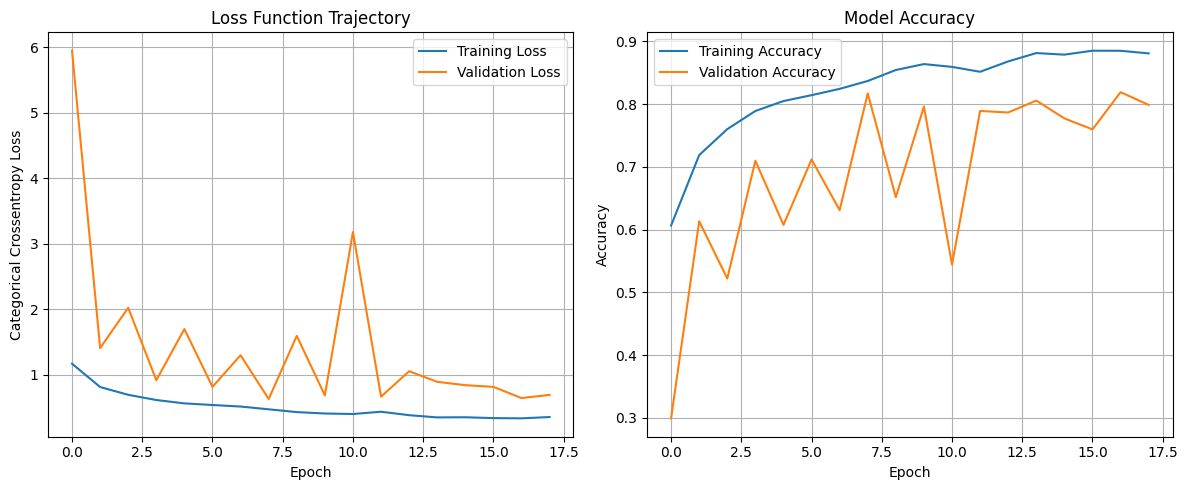

In [ ]:
# Plot Training History

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Function Trajectory')
    plt.ylabel('Categorical Crossentropy Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# Final Evaluation and Prediction

# Load the best model weights
cnn_model.load_weights(model_filepath)

# 1. Final Evaluation (Test Loss and Accuracy)
print("--- Final Evaluation on Test Set ---")
loss, accuracy = cnn_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 2. Make Predictions on the Test Set
# The output is an array of predicted class probabilities (Softmax output)
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_generator.reset()
y_pred_probs = cnn_model.predict(test_generator, steps=STEP_SIZE_TEST + 1, verbose=1)

# Convert probabilities to class labels (index of the max probability)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get the true class labels (indices)
y_true_classes = test_generator.classes[:len(y_pred_classes)]

# Get the class names in the order of the generator
class_labels = list(test_generator.class_indices.keys())

--- Final Evaluation on Test Set ---
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.8192 - loss: 0.6285
Test Loss: 0.6139
Test Accuracy: 0.8274
127/127 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step



--- Classification Report ---
                      precision    recall  f1-score   support

          AnnualCrop     0.8596    0.8844    0.8719       450
              Forest     0.8343    0.9289    0.8791       450
HerbaceousVegetation     0.7575    0.8467    0.7996       450
             Highway     0.8552    0.8347    0.8448       375
          Industrial     0.9771    0.6827    0.8038       375
             Pasture     0.9701    0.5400    0.6938       300
       PermanentCrop     0.8769    0.7787    0.8249       375
         Residential     0.6696    1.0000    0.8021       450
               River     0.8256    0.8080    0.8167       375
             SeaLake     0.9087    0.8400    0.8730       450

            accuracy                         0.8274      4050
           macro avg     0.8535    0.8144    0.8210      4050
        weighted avg     0.8469    0.8274    0.8255      4050



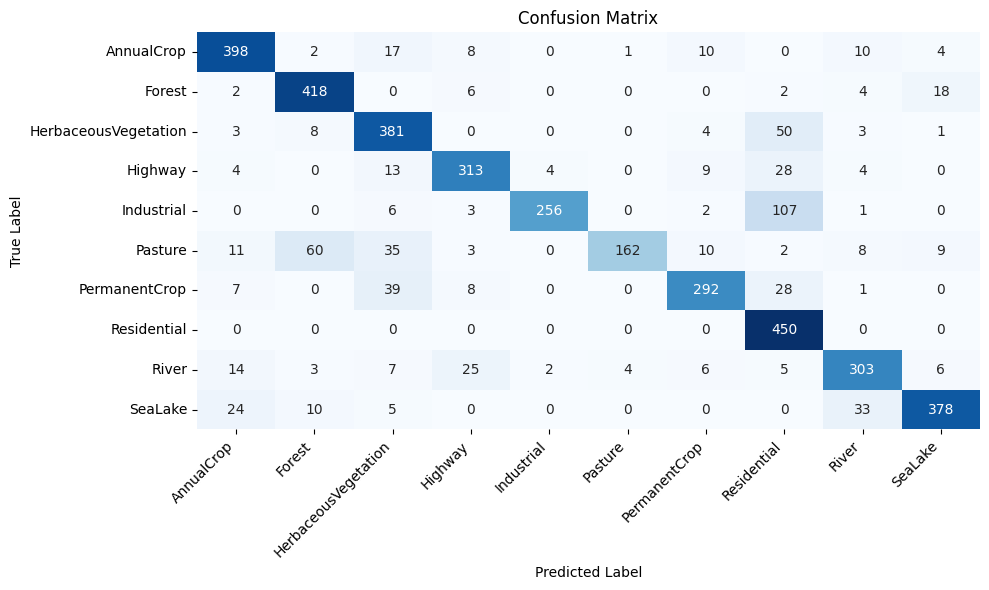

In [ ]:
#Classification Report and Confusion Matrix

# 1. Classification Report
print("\n--- Classification Report ---")
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels, digits=4)
print(report)

# 2. Confusion Matrix Calculation
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 3. Visualization using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from Google Drive...
Model loaded successfully!

Ready for image upload. Please click 'Choose Files'.


Saving Highway_1023.jpg to Highway_1023 (2).jpg


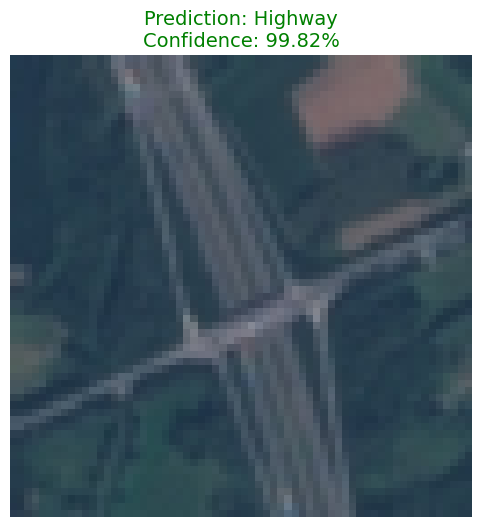


Predicted Class: Highway, Confidence: 0.9982


In [10]:
# --- 1. Setup (Run this first) ---
# Define constants
IMG_SIZE = (64, 64)
CLASS_NAMES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
               'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
               'River', 'SeaLake'] # Copy this directly from your training notebook


DRIVE_LOAD_PATH = '/content/drive/MyDrive/Satellite_Model/CNN_satellite_detection/best_eurosat_cnn_model.keras'

# Mount Drive to access the saved model
drive.mount('/content/drive')

# --- 2. Load the Model (Run this once) ---
print("Loading model from Google Drive...")
try:
    best_model = tf.keras.models.load_model(DRIVE_LOAD_PATH)
    print("Model loaded successfully!")
except Exception as e:
    print(f"ERROR: Could not load model from path. Check the path and file existence: {e}")
    exit()

# --- 3. Inference Function (Re-use from Block 4.0) ---
def preprocess_and_predict(image_path, model, class_names, target_size):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype='float32')
    normalized_img = img_array / 255.0
    input_tensor = np.expand_dims(normalized_img, axis=0)

    prediction_probs = model.predict(input_tensor, verbose=0)[0]
    predicted_class_index = np.argmax(prediction_probs)
    predicted_label = class_names[predicted_class_index]
    confidence = prediction_probs[predicted_class_index]

    return img_array.astype(np.uint8), predicted_label, confidence

# --- 4. Test a New Picture (Run this repeatedly for new tests) ---
print("\nReady for image upload. Please click 'Choose Files'.")
uploaded = files.upload()

if uploaded:
    uploaded_file_name = list(uploaded.keys())[0]

    # Perform prediction
    image_original, label, confidence = preprocess_and_predict(
        uploaded_file_name,
        best_model,
        CLASS_NAMES,
        IMG_SIZE
    )

    # Visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(image_original)
    plt.title(f"Prediction: {label}\nConfidence: {confidence*100:.2f}%",
              fontsize=14, color='green')
    plt.axis('off')
    plt.show()

    print(f"\nPredicted Class: {label}, Confidence: {confidence:.4f}")